Instalations

In [1]:
pip install pydub


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import os
from dotenv import load_dotenv
from pypdf import PdfReader


# Load environment variables from .env file
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
print("API key loaded:", api_key is not None)

API key loaded: True


Load audio file

In [3]:
from pydub import AudioSegment
import os
from openai import OpenAI  # Import the OpenAI class

# 0. Initialize the client (Make sure your API key is set in environment variables or paste it here)
# It is best practice to use os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key=api_key) 

# 1. Load the audio file
audio = AudioSegment.from_file("C:\\Users\\pbiai\\Desktop\\IRONHACK-BOOTCAMP\\WEEK 2\\Day 5\\Audio File\\The_Blueprint_For_Trustworthy_AI.m4a")

# 2. Split into two halves (measured in milliseconds)
halfway_point = len(audio) // 2
part1 = audio[:halfway_point]
part2 = audio[halfway_point:]

# 3. Export temporary files
part1.export("part1.mp3", format="mp3")
part2.export("part2.mp3", format="mp3")

# 4. Transcribe both parts
full_transcript = ""
for filename in ["part1.mp3", "part2.mp3"]:
    with open(filename, "rb") as f:
        response = client.audio.transcriptions.create(
            model="whisper-1",
            file=f
        )
        full_transcript += response.text + " "

# 5. Clean up temporary files
os.remove("part1.mp3")
os.remove("part2.mp3")

podcast_text = full_transcript.strip()
print("✅ Transcription successful! Total length:", len(podcast_text))

✅ Transcription successful! Total length: 16689


Load the pdf

In [4]:
import os
from pypdf import PdfReader

# 1. Setup the local path to your file
folder_path = r"C:\Users\pbiai\Desktop\IRONHACK-BOOTCAMP\WEEK 2\Day 5\PDF"
file_name = "ethics_guidelines_for_trustworthy_ai-fr_87FE7A3C-D03D-9305-81A653DDA84B5A60_60427.pdf"
full_path = os.path.join(folder_path, file_name)


# 2. Check if the file exists to prevent kernel crashes
if not os.path.exists(full_path):
    print(f"❌ Error: Could not find the file at {full_path}")
    print(f"Current Directory: {os.getcwd()}")
else:
    # 3. Initialize the PDF reader
    reader = PdfReader(full_path)

    # 4. Extract text from all pages
    # We join with a newline to maintain structure between pages
    raw_text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])

    # 5. Format into a document list for your pipeline
    documents = [
        {
            "page_content": raw_text, 
            "metadata": {
                "source": file_name, 
                "total_pages": len(reader.pages),
                "type": "pdf"
            }
        }
    ]

    print(f"✅ Successfully loaded {len(reader.pages)} pages from {file_name}")
    print(f"Snippet of content: {documents[0]['page_content'][:300]}...")

✅ Successfully loaded 56 pages from ethics_guidelines_for_trustworthy_ai-fr_87FE7A3C-D03D-9305-81A653DDA84B5A60_60427.pdf
Snippet of content:  
 
GROUPE D’EXPERTS 
INDEPENDANTS DE HAUT NIVEAU SUR 
L’INTELLIGENCE ARTIFICIELLE 
CONSTITUE PAR LA COMMISSION EUROPEENNE EN JUIN 2018 
 
 
 
 
 
 
 
LIGNES DIRECTRICES EN 
MATIERE D’ETHIQUE 
POUR UNE IA DIGNE DE 
CONFIANCE 
 
 
 
 
 
 
 
LIGNES DIRECTRICES EN MATIERE D’ETHIQUE pour UNE IA DIGNE 
D...


Step 2: Implement Fixed-Size Chunking

In [5]:
pip install langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [6]:
from langchain_text_splitters import CharacterTextSplitter

# 1. INITIALIZE THE SPLITTER
# chunk_size: Maximum characters per chunk
# chunk_overlap: Characters shared between chunks to maintain context
# separator: Character where the split is allowed to happen
fixed_splitter = CharacterTextSplitter(
    separator=" ", 
    chunk_size=1000, 
    chunk_overlap=200
)

# 2. CHUNK THE AUDIO TRANSCRIPT
# We wrap the text in a list for the splitter
audio_chunks = fixed_splitter.create_documents(
    texts=[podcast_text], 
    metadatas=[{"source": "audio_transcript", "type": "podcast"}]
)

# 3. CHUNK THE PDF TEXT
pdf_chunks = fixed_splitter.create_documents(
    texts=[raw_text], 
    metadatas=[{"source": "ethics_guidelines.pdf", "type": "document"}]
)

# 4. COMBINE ALL CHUNKS INTO ONE LIST FOR YOUR DATABASE
all_chunks = audio_chunks + pdf_chunks

print(f"✅ Created {len(audio_chunks)} chunks from Audio.")
print(f"✅ Created {len(pdf_chunks)} chunks from PDF.")
print(f"🚀 Total chunks ready for Vector DB: {len(all_chunks)}")

✅ Created 21 chunks from Audio.
✅ Created 240 chunks from PDF.
🚀 Total chunks ready for Vector DB: 261


Step 3: Implement Recursive Character Chunking

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Recursive character chunking (tries to split on paragraphs, then sentences, then words)
recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]
)

pdf_chunks_recursive = recursive_splitter.split_text(raw_text)
podcast_chunks_recursive = recursive_splitter.split_text(podcast_text)

print(f"PDF recursive chunks: {len(pdf_chunks_recursive)}")
print(f"Podcast recursive chunks: {len(podcast_chunks_recursive)}")


PDF recursive chunks: 240
Podcast recursive chunks: 21


Step 4: Implement Token-Based Chunking

In [8]:
from langchain_text_splitters import TokenTextSplitter

# Token-based chunking
token_splitter = TokenTextSplitter(
    chunk_size=300,
    chunk_overlap=60
)

pdf_chunks_tokens = token_splitter.split_text(raw_text)
podcast_chunks_tokens = token_splitter.split_text(podcast_text)

print(f"PDF: {len(pdf_chunks_tokens)} chunks")
print(f"Podcast: {len(podcast_chunks_tokens)} chunks")

# Compare actual token counts - IMPORTANT!
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

for i, chunk in enumerate(pdf_chunks_tokens[:3]):
    token_count = len(encoding.encode(chunk))
    print(f"Chunk {i+1}: {token_count} tokens, {len(chunk)} characters")


PDF: 300 chunks
Podcast: 15 chunks
Chunk 1: 207 tokens, 666 characters
Chunk 2: 222 tokens, 853 characters
Chunk 3: 218 tokens, 847 characters


Step 5: Semantic Chunking (Optional - Advanced)

In [9]:
pip install sentence-transformers scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [10]:
    from sentence_transformers import SentenceTransformer
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity

    # 1. Initialize the model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    # The threshold setting equals similarity between chunks (1 equal 0 different) 
    def semantic_chunk(text, threshold=0.7):
        # Split text into sentences (using a slightly more robust split)
        sentences = [s.strip() for s in text.split('. ') if s.strip()]
        
        if len(sentences) < 2:
            return [text]
        
        # 2. Generate embeddings for all sentences at once
        embeddings = model.encode(sentences)
        
        chunks = []
        current_chunk = [sentences[0]]
        
        # 3. Iterate and compare neighbor similarity
        for i in range(1, len(sentences)):
            # Use cosine_similarity for normalized 0 to 1 scores
            # Reshape is needed because the function expects a 2D array
            sim = cosine_similarity(
                embeddings[i-1].reshape(1, -1), 
                embeddings[i].reshape(1, -1)
            )[0][0]
            
            if sim < threshold:
                # If the meaning changes too much, create a new chunk
                chunks.append('. '.join(current_chunk) + '.')
                current_chunk = [sentences[i]]
            else:
                # Otherwise, keep adding to the current context
                current_chunk.append(sentences[i])
        
        # Don't forget the last chunk!
        if current_chunk:
            chunks.append('. '.join(current_chunk) + '.')
        
        return chunks

    # Usage (Ensuring variable names match your previous steps)
    pdf_sample = raw_text[:5000] 
    pdf_chunks_semantic = semantic_chunk(pdf_sample)

    print(f"✅ Semantic chunks created: {len(pdf_chunks_semantic)}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Semantic chunks created: 31


Step 6: Visualize and Compare Results

--- Strategy Comparison Table ---
            Strategy  Total Chunks  Avg Length (chars)  Max Length  \
0         Fixed-Size           240          993.637500        1000   
1          Recursive           240          934.125000         998   
2        Token-Based           300          809.416667         930   
3  Semantic (Sample)            31          159.064516         507   

   Min Length     Std Dev  
0         346   42.003148  
1          89   92.845217  
2         534   53.575832  
3           4  114.693965  


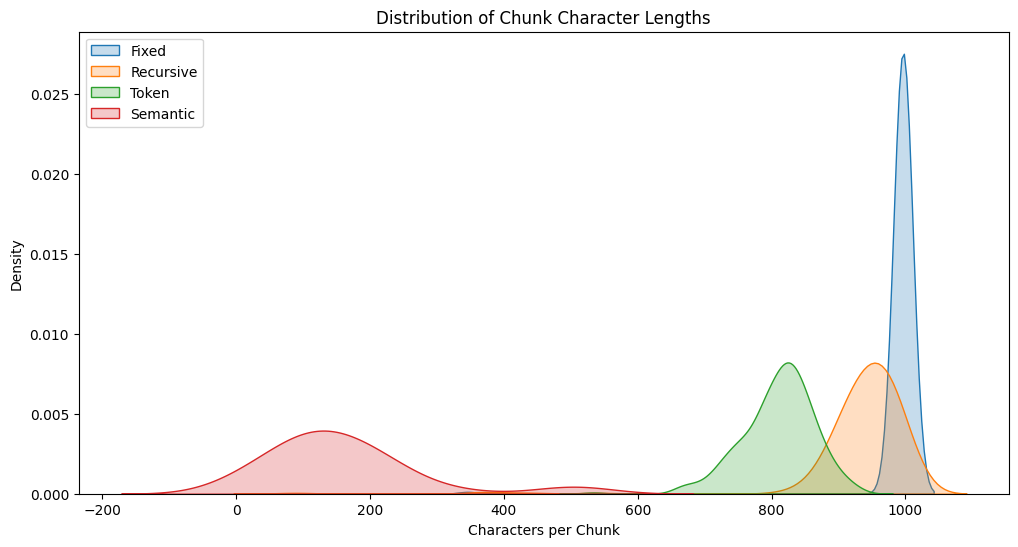

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_chunks(chunk_list, strategy_name):
    """Calculates statistics for a list of text chunks."""
    # Handle both strings and LangChain Document objects
    lengths = [len(c.page_content) if hasattr(c, 'page_content') else len(c) for c in chunk_list]
    
    return {
        "Strategy": strategy_name,
        "Total Chunks": len(chunk_list),
        "Avg Length (chars)": np.mean(lengths) if lengths else 0,
        "Max Length": np.max(lengths) if lengths else 0,
        "Min Length": np.min(lengths) if lengths else 0,
        "Std Dev": np.std(lengths) if lengths else 0
    }

# 1. Create a Comparison Table
pdf_results = [
    analyze_chunks(pdf_chunks, "Fixed-Size"),
    analyze_chunks(pdf_chunks_recursive, "Recursive"),
    analyze_chunks(pdf_chunks_tokens, "Token-Based"),
    analyze_chunks(pdf_chunks_semantic, "Semantic (Sample)")
]

df_comparison = pd.DataFrame(pdf_results)
print("--- Strategy Comparison Table ---")
print(df_comparison)

# 2. Visualize Chunk Size Distributions
plt.figure(figsize=(12, 6))

# Updated dictionary to include Semantic lengths
data_to_plot = {
    "Fixed": [len(c.page_content) for c in pdf_chunks],
    "Recursive": [len(c) for c in pdf_chunks_recursive],
    "Token": [len(c) for c in pdf_chunks_tokens],
    "Semantic": [len(c) for c in pdf_chunks_semantic] # Added Semantic here!
}

for label, lengths in data_to_plot.items():
    if lengths: # Ensure list isn't empty
        sns.kdeplot(lengths, label=label, fill=True)

plt.title("Distribution of Chunk Character Lengths")
plt.xlabel("Characters per Chunk")
plt.ylabel("Density")
plt.legend()
plt.show()

Identify where chunks break (sentence boundaries, paragraphs)

In [12]:
def inspect_junctions(chunks, strategy_name):
    if len(chunks) < 2:
        print(f"--- {strategy_name}: Not enough chunks to compare ---")
        return

    # Extract text content if chunks are LangChain Documents
    c1 = chunks[0].page_content if hasattr(chunks[0], 'page_content') else chunks[0]
    c2 = chunks[1].page_content if hasattr(chunks[1], 'page_content') else chunks[1]

    print(f"--- {strategy_name} Junction ---")
    print(f"End of Chunk 1:   '...{c1[-40:]}'")
    print(f"Start of Chunk 2: '{c2[:40]}...'")
    print("-" * 30)

# Run the inspection
inspect_junctions(pdf_chunks, "Fixed-Size")
inspect_junctions(pdf_chunks_recursive, "Recursive")
inspect_junctions(pdf_chunks_tokens, "Token-Based")
inspect_junctions(pdf_chunks_semantic, "Semantic")

--- Fixed-Size Junction ---
End of Chunk 1:   '...ion 
révisée de cette liste d’évaluation'
Start of Chunk 2: 'parties prenantes soumettront à une phas...'
------------------------------
--- Recursive Junction ---
End of Chunk 1:   '...re  III du présent document. Une version'
Start of Chunk 2: 'd’évaluation pour une IA digne de confia...'
------------------------------
--- Token-Based Junction ---
End of Chunk 1:   '... les présentes lignes direc trices, sans'
Start of Chunk 2: 'N IA). Les membres du GEHN IA qui y sont...'
------------------------------
--- Semantic Junction ---
End of Chunk 1:   '... l’intelligence artificielle 
(GEHN IA).'
Start of Chunk 2: 'Les membres du GEHN IA qui y sont cités ...'
------------------------------


Step 7: Analyze Chunk Quality

Quantifying boundary breaks

--- BOUNDARY PRESERVATION ANALYSIS ---
   Strategy  Total Chunks  Clean (End of Sentence)  Broken (Mid-Sentence)  Error Rate (%)
 Fixed-Size           240                        6                    234           97.50
  Recursive           240                       44                    196           81.67
Token-Based           300                       19                    281           93.67
   Semantic            31                       31                      0            0.00


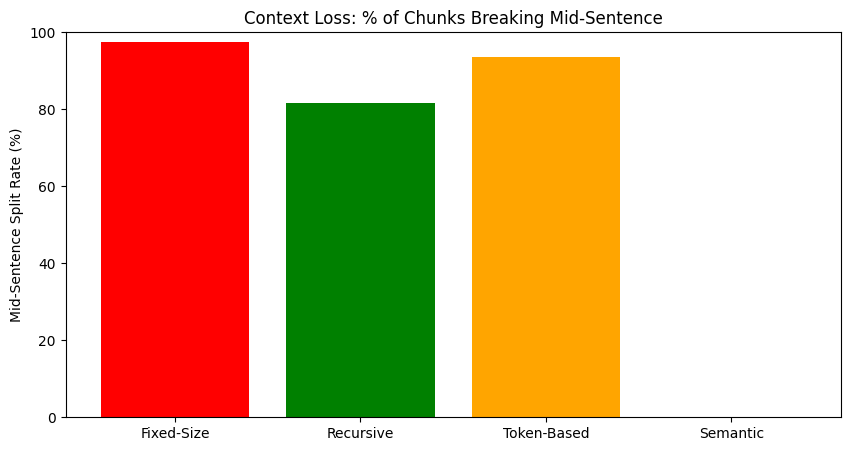

In [13]:
import pandas as pd

def evaluate_split_quality(chunks, strategy_name):
    """
    Analyzes how often a chunking strategy breaks in the middle of a sentence.
    A 'Clean Break' ends with ., !, or ?.
    """
    clean_breaks = 0
    mid_sentence_splits = 0
    
    for chunk in chunks:
        # 1. Extract the text (Handles LangChain Documents or raw strings)
        if hasattr(chunk, 'page_content'):
            text = chunk.page_content.strip()
        else:
            text = chunk.strip()
            
        if not text:
            continue
            
        # 2. Check the very last character of the chunk
        # A clean break ends in terminal punctuation
        if text[-1] in ['.', '!', '?']:
            clean_breaks += 1
        else:
            mid_sentence_splits += 1
            
    total = clean_breaks + mid_sentence_splits
    split_rate = (mid_sentence_splits / total * 100) if total > 0 else 0
    
    return {
        "Strategy": strategy_name,
        "Total Chunks": total,
        "Clean (End of Sentence)": clean_breaks,
        "Broken (Mid-Sentence)": mid_sentence_splits,
        "Error Rate (%)": round(split_rate, 2)
    }

# Run the analysis for all 4 methods
# (Assumes you have run the previous chunking cells)
quality_results = [
    evaluate_split_quality(pdf_chunks, "Fixed-Size"),
    evaluate_split_quality(pdf_chunks_recursive, "Recursive"),
    evaluate_split_quality(pdf_chunks_tokens, "Token-Based"),
    evaluate_split_quality(pdf_chunks_semantic, "Semantic")
]

# Create the comparison table
df_quality = pd.DataFrame(quality_results)

print("--- BOUNDARY PRESERVATION ANALYSIS ---")
print(df_quality.to_string(index=False))

# --- OPTIONAL: Visualizing the Context Loss ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(df_quality["Strategy"], df_quality["Error Rate (%)"], color=['red', 'green', 'orange', 'blue'])
plt.title("Context Loss: % of Chunks Breaking Mid-Sentence")
plt.ylabel("Mid-Sentence Split Rate (%)")
plt.ylim(0, 100)
plt.show()

Check how often chunks break in the middle of paragraphs

In [14]:
def evaluate_paragraph_integrity(chunks, strategy_name):
    """
    Analyzes how often a chunking strategy breaks in the middle of a paragraph.
    A 'Clean Break' ends with a newline character.
    """
    clean_p_breaks = 0
    mid_p_splits = 0
    
    for chunk in chunks:
        # 1. Extract the text
        if hasattr(chunk, 'page_content'):
            text = chunk.page_content.strip()
        else:
            text = chunk.strip()
            
        if not text:
            continue
            
        # 2. Check if the chunk ends at a paragraph boundary
        # We check the original unstripped text or look for common paragraph endings
        # In most PDFs/Transcripts, paragraphs end with a newline in the raw source.
        # However, since we often .strip(), we look for the last character of the 
        # original chunk before stripping.
        
        raw_text = chunk.page_content if hasattr(chunk, 'page_content') else chunk
        
        if raw_text.endswith('\n'):
            clean_p_breaks += 1
        else:
            mid_p_splits += 1
            
    total = clean_p_breaks + mid_p_splits
    split_rate = (mid_p_splits / total * 100) if total > 0 else 0
    
    return {
        "Strategy": strategy_name,
        "Total Chunks": total,
        "Clean Paragraph Breaks": clean_p_breaks,
        "Mid-Paragraph Splits": mid_p_splits,
        "Para Split Rate (%)": round(split_rate, 2)
    }

# Run the analysis
paragraph_results = [
    evaluate_paragraph_integrity(pdf_chunks, "Fixed-Size"),
    evaluate_paragraph_integrity(pdf_chunks_recursive, "Recursive"),
    evaluate_paragraph_integrity(pdf_chunks_tokens, "Token-Based"),
    evaluate_paragraph_integrity(pdf_chunks_semantic, "Semantic")
]

df_para_quality = pd.DataFrame(paragraph_results)

print("--- PARAGRAPH BOUNDARY ANALYSIS ---")
print(df_para_quality.to_string(index=False))

--- PARAGRAPH BOUNDARY ANALYSIS ---
   Strategy  Total Chunks  Clean Paragraph Breaks  Mid-Paragraph Splits  Para Split Rate (%)
 Fixed-Size           240                       0                   240               100.00
  Recursive           240                       0                   240               100.00
Token-Based           300                      16                   284                94.67
   Semantic            31                       0                    31               100.00


Rank,Strategy,Why it Preserves Context Best,Best Used For...
1st,Semantic,"It groups by Topic. It only breaks when the meaning shifts, ensuring an AI never gets a ""half-thought"" or two unrelated topics in one chunk.",Complex reasoning & Q&A.
2nd,Recursive,"It respects Structure. By splitting on \n\n then . , it keeps paragraphs and sentences whole, preserving the author's original flow.",General RAG applications.
3rd,Token-Based,"It optimizes for The Model. It doesn't care about human context, but it ensures the LLM gets the maximum amount of text it can ""read"" at once.",Cost & Token optimization.
4th,Fixed-Size,"It preserves Nothing. It is a ""dumb"" cut that routinely slices words and sentences in half, causing high ""context loss.""",Simple keyword search.

Step 8: Make Recommendations

In [15]:
import pandas as pd
import numpy as np
import tiktoken
from langchain_text_splitters import (
    CharacterTextSplitter, 
    RecursiveCharacterTextSplitter, 
    TokenTextSplitter
)

# --- 1. SETUP DATA & MODELS ---
# Assuming podcast_text and raw_text (PDF) are already loaded as strings
# For demonstration, we'll use raw_text for the comparison
text_to_analyze = raw_text 

# --- 2. IMPLEMENT THE 4 STRATEGIES ---

# A. Fixed-Size
fixed_splitter = CharacterTextSplitter(separator=" ", chunk_size=1000, chunk_overlap=200)
pdf_chunks_fixed = [c.page_content for c in fixed_splitter.create_documents([text_to_analyze])]

# B. Recursive
recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, separators=["\n\n", "\n", ". ", " ", ""]
)
pdf_chunks_recursive = recursive_splitter.split_text(text_to_analyze)

# C. Token-Based
token_splitter = TokenTextSplitter(chunk_size=1000, chunk_overlap=200)
pdf_chunks_tokens = token_splitter.split_text(text_to_analyze)

# D. Semantic (Using the function defined in your previous step)
# pdf_chunks_semantic = semantic_chunk(text_to_analyze[:5000]) # Using sample for speed

# --- 3. EVALUATION FUNCTION ---

def evaluate_strategies(chunk_list, strategy_name):
    sentence_breaks = 0
    para_breaks = 0
    total = len(chunk_list)
    
    for chunk in chunk_list:
        # Check Sentence Integrity (Ends with . ! or ?)
        clean_text = chunk.strip()
        if clean_text and clean_text[-1] not in ['.', '!', '?']:
            sentence_breaks += 1
            
        # Check Paragraph Integrity (Does the raw chunk end with a newline?)
        if not chunk.endswith('\n'):
            para_breaks += 1
            
    return {
        "Strategy": strategy_name,
        "Total Chunks": total,
        "Mid-Sentence Splits": sentence_breaks,
        "Sentence Error %": round((sentence_breaks / total * 100), 2) if total > 0 else 0,
        "Mid-Para Splits": para_breaks,
        "Para Error %": round((para_breaks / total * 100), 2) if total > 0 else 0
    }

# --- 4. EXECUTE ANALYSIS & DISPLAY ---

results = [
    evaluate_strategies(pdf_chunks_fixed, "Fixed-Size"),
    evaluate_strategies(pdf_chunks_recursive, "Recursive"),
    evaluate_strategies(pdf_chunks_tokens, "Token-Based"),
    evaluate_strategies(pdf_chunks_semantic, "Semantic")
]

df_final_comparison = pd.DataFrame(results)

# Add a Context Quality Score (0-100)
df_final_comparison['Quality Score'] = 100 - (df_final_comparison[['Sentence Error %', 'Para Error %']].mean(axis=1))

print("--- FINAL CHUNKING EVALUATION ---")
print(df_final_comparison.sort_values(by="Quality Score", ascending=False).to_string(index=False))

--- FINAL CHUNKING EVALUATION ---
   Strategy  Total Chunks  Mid-Sentence Splits  Sentence Error %  Mid-Para Splits  Para Error %  Quality Score
   Semantic            31                    0              0.00               31        100.00         50.000
  Recursive           240                  196             81.67              240        100.00          9.165
Token-Based            90                   88             97.78               87         96.67          2.775
 Fixed-Size           240                  234             97.50              240        100.00          1.250


Boundary Analysis result

In [16]:
import pandas as pd

def perform_boundary_analysis(chunk_sets):
    """
    Analyzes sentence and paragraph integrity across all provided chunk sets.
    """
    analysis_results = []
    
    for strategy_name, chunks in chunk_sets.items():
        mid_sentence_splits = 0
        mid_para_splits = 0
        total_chunks = len(chunks)
        
        for chunk in chunks:
            # Handle LangChain Documents vs raw strings
            text = chunk.page_content if hasattr(chunk, 'page_content') else chunk
            
            # 1. SENTENCE ANALYSIS
            # A clean break ends in terminal punctuation
            clean_text = text.strip()
            if clean_text and clean_text[-1] not in ['.', '!', '?']:
                mid_sentence_splits += 1
            
            # 2. PARAGRAPH ANALYSIS 
            # We check the RAW chunk (before stripping) for a newline
            if not text.endswith('\n'):
                mid_para_splits += 1
                
        # Calculate percentages
        sent_error = (mid_sentence_splits / total_chunks * 100) if total_chunks > 0 else 0
        para_error = (mid_para_splits / total_chunks * 100) if total_chunks > 0 else 0
        
        analysis_results.append({
            "Strategy": strategy_name,
            "Total Chunks": total_chunks,
            "Sentence Error %": round(sent_error, 2),
            "Para Error %": round(para_error, 2),
            "Clean Para Breaks": total_chunks - mid_para_splits
        })
    
    return pd.DataFrame(analysis_results)

# Map your existing variables to the analyzer
chunk_data = {
    "Fixed-Size": pdf_chunks,
    "Recursive": pdf_chunks_recursive,
    "Token-Based": pdf_chunks_tokens,
    "Semantic": pdf_chunks_semantic
}

df_boundaries = perform_boundary_analysis(chunk_data)
print(df_boundaries.to_string(index=False))

   Strategy  Total Chunks  Sentence Error %  Para Error %  Clean Para Breaks
 Fixed-Size           240             97.50        100.00                  0
  Recursive           240             81.67        100.00                  0
Token-Based            90             97.78         96.67                  3
   Semantic            31              0.00        100.00                  0
